In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Basic stats

## Read coverage

In [25]:
def load_depth(sample_id, chrom, n_every = 1):
    depth_path = f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13/{sample_id}/chm13.{sample_id}.{chrom}.depth.txt.gz"

    res = subprocess.run(f"zcat {depth_path} | awk 'NR % {n_every} == 0'", shell=True, capture_output=True)
    
    df = pl.read_csv(
        io.BytesIO(res.stdout),
        separator="\t",
        new_columns=["chrom", "pos_1based", "depth"],
    )

    return df

In [ ]:
%%time
stats = []

def runme(sample_id, chrom, n_every):
    df = load_depth(sample_id, chrom, n_every)
    return [sample_id, chrom, len(df), df["depth"].mean()]
    
stats = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(sample_id, chrom, 1000) for sample_id in sample_ids for chrom in aut_chrom_names
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 11.6min


In [95]:
stats_df = (pl.DataFrame(stats, schema=["sample_id", "chrom", "n_sites", "mean_depth"])
    .group_by("sample_id")
    .agg(
        n_total = pl.col("n_sites").sum(),
        weighted_sum = (pl.col("n_sites") * pl.col("mean_depth")).sum(),
    )
    .select(
        "sample_id",
        (pl.col("weighted_sum") / pl.col("n_total")).alias("mean_depth"),
    )
    .sort("mean_depth")
)

In [96]:
stats_df

sample_id,mean_depth
str,f64
"""PD50508f""",15.652876
"""PD50508b""",20.623035
"""PD50489e""",22.238416
"""PD50519d""",23.319102
"""PD50523b""",24.503857
"""PD50521e""",25.114194
"""PD50477f""",25.343984
"""PD46180c""",31.714647
"""PD50521b""",33.258736


In [92]:
stats_df.mean()

sample_id,mean_depth
str,f64
null,24.640983


## Get read counts

In [5]:
read_length_means = {}
read_length_stds = {}
read_numbers = {}

ccs_read_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/")

for sample_id in rahbari_sample_ids:
    count_path = ccs_read_path / sample_id / (sample_id + ".ccs.filtered.fastqc")
    d = open(count_path).read().strip().split()
    read_numbers[sample_id] = int(d[1])
    read_length_means[sample_id] = float(d[3])
    read_length_stds[sample_id] = float(d[4])
    
for sample_id in sudmant_sample_ids:
    path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/PeterSudmant") / sample_id
    read_numbers_total = 0
    read_length_means_total = 0
    for filename in path.glob("*.ccs.stats.txt"):
        with open(filename) as F:
            x = F.readlines()[2].split()
            read_numbers_total += int(x[1].replace(",",""))
            read_length_means_total += int(x[3].replace(",",""))
    read_numbers[sample_id] = read_numbers_total
    read_length_means[sample_id] = read_length_means_total
    read_length_stds[sample_id] = 0
    
for sample_id in normal_sample_ids:
    path = Path("/lustre/scratch126/casm/team154pc/sl17/01.himut/01.data/ccs/") / sample_id / f"{sample_id}.ccs.filtered.fastq.stat"
    d = dict([x.strip().split(": ") for x in open(path).read().strip().splitlines()])
    read_numbers[sample_id] = int(d["number_of_sequences"])
    read_length_means[sample_id] = float(d["mean"])
    read_length_stds[sample_id] = float(d["std"])

In [6]:
display(read_numbers)

{'PD50477f': 7185241,
 'PD50519d': 5353906,
 'PD50508f': 3040994,
 'PD50523b': 4741878,
 'PD50521b': 6113622,
 'PD50508b': 3947659,
 'PD46180c': 5936129,
 'PD50521e': 6168195,
 'PD50489e': 6065965,
 '1894': 9181560,
 '3898': 8634738,
 '7899': 10220204,
 '95619': 8876456,
 '115980': 9037595,
 '2895': 6982155,
 'PD47269d': 12659998,
 'PD48473b': 4949180}

In [17]:
print("Total number of reads (before any processing):", np.sum(list(read_numbers.values())))

Total number of reads (before any processing): 101486297


In [18]:
print("Average read length:", np.mean(list(read_length_means.values())))

Average read length: 21778.8143966443


In [7]:
read_length_means

{'PD50477f': 13465.900949042627,
 'PD50519d': 14053.125118184742,
 'PD50508f': 17011.82899703189,
 'PD50523b': 15500.8475274986,
 'PD50521b': 15827.801594374007,
 'PD50508b': 15688.517728354956,
 'PD46180c': 16380.781127903387,
 'PD50521e': 12234.025510380265,
 'PD50489e': 11014.38739689398,
 '1894': 33284,
 '3898': 34453,
 '7899': 31966,
 '95619': 32162,
 '115980': 30573,
 '2895': 33067,
 'PD47269d': 16632.168035097635,
 'PD48473b': 18270.600806194157}

In [8]:
read_length_stds

{'PD50477f': 2589.3969203803667,
 'PD50519d': 3806.4821315357935,
 'PD50508f': 3318.579196835446,
 'PD50523b': 3477.5704405533756,
 'PD50521b': 3761.3441791718737,
 'PD50508b': 3065.206519273185,
 'PD46180c': 3713.4639503032836,
 'PD50521e': 4412.44918173114,
 'PD50489e': 6058.533851761193,
 '1894': 0,
 '3898': 0,
 '7899': 0,
 '95619': 0,
 '115980': 0,
 '2895': 0,
 'PD47269d': 3743.4601507764064,
 'PD48473b': 1753.9346608350136}

## Distribution (use only first 100,000 reads for speed)

In [40]:
%%time
from Bio import SeqIO
import gzip

def runme(sample_id):
    path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/PeterSudmant") / sample_id
    read_lengths = []
    for filename in path.glob("*.ccs.filtered.fastq.gz"):
        cmd = "gzip -cd XXX | awk 'NR%4==2 {print length($0)} NR>=400000 {exit}' | awk '{sum+=$1; sumsq+=$1*$1; count++} END {print \"Mean =\", sum/count; print \"STD =\", sqrt(sumsq/count - (sum/count)**2)}'"
        cmd = cmd.replace("XXX", str(filename))
        ret = subprocess.getoutput(cmd)

    return (sample_id, ret)

rows = joblib.Parallel(n_jobs=-1, verbose=50)(
    joblib.delayed(runme)(sample_id) for sample_id in sudmant_sample_ids
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  1.0min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.1min remaining:   33.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.8min finished
CPU times: user 79.4 ms, sys: 21.9 ms, total: 101 ms
Wall time: 1min 46s


In [41]:
rows

[('1894', 'Mean = 17774.8\nSTD = 4891.64'),
 ('3898', 'Mean = 18987.7\nSTD = 5180.81'),
 ('7899', 'Mean = 16820.1\nSTD = 4614.91'),
 ('95619', 'Mean = 16997.6\nSTD = 4942.39'),
 ('115980', 'Mean = 16296.5\nSTD = 4748.35'),
 ('2895', 'Mean = 17501.5\nSTD = 4359.6')]

# Get read counts after filtering

In [24]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:08<00:00,  1.78it/s]

CPU times: user 138 ms, sys: 173 ms, total: 310 ms
Wall time: 8.42 s


In [25]:
(reads_df
    .filter(pl.col("is_high_quality_read"))
    .select(pl.len())
).collect()

len
u32
74380961


## Get read lengths

In [16]:
def get_read_lengths(focal_sample_id, chrom):
    read_lengths = (reads_df
        .filter("is_high_quality_read")
        .filter((pl.col("sample_id") == focal_sample_id) & (pl.col("chrom") == chrom))
        .select("read_length")
    )

    stats = (read_lengths
        .with_columns(
            one=pl.lit(1),
        )
        .select(
            pl.col("one").sum().alias("n_reads"),
            pl.col("read_length").mean().alias("mean"),
            pl.col("read_length").quantile(0.01).alias("q_0.01"),
            pl.col("read_length").quantile(0.05).alias("q_0.05"),
            pl.col("read_length").quantile(0.95).alias("q_0.95"),
            pl.col("read_length").quantile(0.99).alias("q_0.99"),
            pl.col("read_length").quantile(0.5).alias("median"),
        )
        .collect(streaming=True)
        .with_columns(
            sample_id = pl.lit(focal_sample_id),
            chrom = pl.lit(chrom),
        )
    )
    
    return stats


In [17]:
%%time
read_stats_df = pl.concat([
    get_read_lengths(sample_id, chrom) for sample_id in tqdm.tqdm(sample_ids) for chrom in aut_chrom_names
])



  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:34<04:32, 34.06s/it]

 22%|██▏       | 2/9 [01:07<03:54, 33.44s/it]

 33%|███▎      | 3/9 [01:38<03:16, 32.75s/it]

 44%|████▍     | 4/9 [02:11<02:43, 32.76s/it]

 56%|█████▌    | 5/9 [02:43<02:10, 32.53s/it]

 67%|██████▋   | 6/9 [03:17<01:38, 32.80s/it]

 78%|███████▊  | 7/9 [03:50<01:06, 33.02s/it]

 89%|████████▉ | 8/9 [04:23<00:32, 32.87s/it]

100%|██████████| 9/9 [04:55<00:00, 32.79s/it]

CPU times: user 9min 50s, sys: 1min 9s, total: 10min 59s
Wall time: 4min 55s


In [18]:
read_stats_df

n_reads,mean,q_0.01,q_0.05,q_0.95,q_0.99,median,sample_id,chrom
i32,f64,f64,f64,f64,f64,f64,str,str
346586,13488.539993,9533.0,10283.0,18445.0,20702.0,12975.0,"""PD50477f""","""chr1"""
376401,13459.855603,9524.0,10278.0,18390.0,20673.0,12944.0,"""PD50477f""","""chr2"""
310556,13466.844179,9527.0,10277.0,18415.0,20682.0,12949.0,"""PD50477f""","""chr3"""
294780,13427.849915,9500.0,10267.0,18354.0,20646.0,12912.0,"""PD50477f""","""chr4"""
279809,13455.127483,9524.0,10274.0,18378.0,20633.0,12946.0,"""PD50477f""","""chr5"""
…,…,…,…,…,…,…,…,…
125596,11556.605521,3182.0,4201.0,23059.0,28312.0,10336.0,"""PD50489e""","""chr18"""
72784,11248.589168,3118.0,4251.0,22524.0,27762.0,9840.0,"""PD50489e""","""chr19"""
97782,11707.025046,3189.0,4290.0,23066.0,28392.0,10558.0,"""PD50489e""","""chr20"""


In [19]:
display(read_length_means)

  0%|          | 0/9 [05:58<?, ?it/s]


NameError: name 'read_length_means' is not defined

In [38]:
print(
    "Average read length:", 
    np.sum([read_length_means[sample_id] * read_numbers[sample_id] for sample_id in sample_ids]) / np.sum(list(read_numbers.values())),
)

Average read length: 14323.187104500143


# Number of SNPs

In [16]:
all_snps = pl.concat(
    [pl.scan_parquet(
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
    ).with_columns(sample_id=pl.lit(focal_sample_id))
        for focal_sample_id in sample_ids
        for chrom in aut_chrom_names
    ]
)

In [27]:
%%time
all_snps.select(pl.len()).collect()

CPU times: user 193 ms, sys: 65 ms, total: 258 ms
Wall time: 365 ms


len
u32
1350558687


In [28]:
%%time
all_snps.filter("is_high_quality_snp").select(pl.len()).collect()

CPU times: user 48.8 s, sys: 27.3 s, total: 1min 16s
Wall time: 1min 32s


len
u32
688870303


## High quality SNPs per individual

In [7]:
rows = []
for focal_sample_id in tqdm.tqdm(sample_ids):
    print("sample_id", focal_sample_id)
    sample_snps = pl.concat(
        [pl.scan_parquet(
            Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                    / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
        ).with_columns(sample_id=pl.lit(focal_sample_id))
            for chrom in aut_chrom_names
        ]
    )
    unique_snp_counts = (sample_snps
        .filter("is_high_quality_snp")
        .unique(subset=["ref1_name", "ref1_start", "ref2_name", "ref2_start"])
        .select(pl.len())
        .collect(streaming=True)
    )
    print(unique_snp_counts.item())
    rows.append((focal_sample_id, unique_snp_counts.item()))

  0%|          | 0/15 [00:00<?, ?it/s]

sample_id PD50477f


  7%|▋         | 1/15 [00:08<01:55,  8.25s/it]

1863231
sample_id PD50519d


 13%|█▎        | 2/15 [00:52<06:22, 29.43s/it]

1770307
sample_id PD50508f


 20%|██        | 3/15 [01:37<07:17, 36.50s/it]

1711665
sample_id PD50523b


 27%|██▋       | 4/15 [02:20<07:11, 39.21s/it]

1840848
sample_id PD50521b


 33%|███▎      | 5/15 [03:09<07:07, 42.80s/it]

1857469
sample_id PD50508b


 40%|████      | 6/15 [03:53<06:29, 43.23s/it]

1822784
sample_id PD46180c


 47%|████▋     | 7/15 [04:41<05:55, 44.48s/it]

1845095
sample_id PD50521e


 53%|█████▎    | 8/15 [05:21<05:02, 43.23s/it]

1832813
sample_id PD50489e


 60%|██████    | 9/15 [06:08<04:25, 44.31s/it]

1814361
sample_id 1894


 67%|██████▋   | 10/15 [07:23<04:28, 53.73s/it]

1890167
sample_id 3898


 73%|███████▎  | 11/15 [08:34<03:56, 59.09s/it]

1851566
sample_id 7899


 80%|████████  | 12/15 [09:58<03:19, 66.59s/it]

1883003
sample_id 95619


 87%|████████▋ | 13/15 [11:16<02:20, 70.32s/it]

1880505
sample_id 115980


 93%|█████████▎| 14/15 [12:32<01:11, 71.77s/it]

1917897
sample_id 2895


100%|██████████| 15/15 [13:33<00:00, 54.24s/it]

1825149


In [8]:
rows

[('PD50477f', 1863231),
 ('PD50519d', 1770307),
 ('PD50508f', 1711665),
 ('PD50523b', 1840848),
 ('PD50521b', 1857469),
 ('PD50508b', 1822784),
 ('PD46180c', 1845095),
 ('PD50521e', 1832813),
 ('PD50489e', 1814361),
 ('1894', 1890167),
 ('3898', 1851566),
 ('7899', 1883003),
 ('95619', 1880505),
 ('115980', 1917897),
 ('2895', 1825149)]

In [11]:
np.max([x[1] for x in rows])

1917897

## High quality SNPs per read

In [22]:
rows = []
for focal_sample_id in tqdm.tqdm(sample_ids):
    for chrom in aut_chrom_names:        
        sample_snps = \
            pl.scan_parquet(
                Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.snps.parquet"
            )
        unique_snp_counts = (sample_snps
            .filter("is_high_quality_snp")
            .group_by("read_name")
            .len().rename({"len": "n_snps"})
            .group_by("n_snps")
            .len()
            .collect(streaming=True)
        )
        rows.append((focal_sample_id, chrom, unique_snp_counts))

100%|██████████| 15/15 [03:55<00:00, 15.72s/it]


In [42]:
total_hist = {s:np.zeros(400) for s in sample_ids + ["All"]}
for row in rows:
    for n_snps, cnt in row[2].rows():
        total_hist[row[0]][n_snps] += cnt
        total_hist["All"][n_snps] += cnt

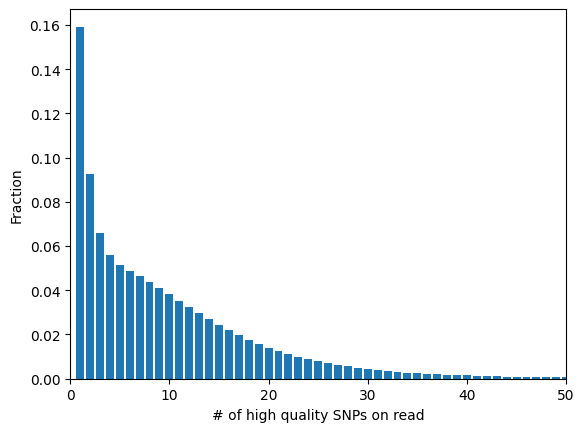

In [46]:
plt.bar(x=np.arange(400), height=total_hist["All"] / total_hist["All"].sum())
plt.xlim(0, 50)
plt.xlabel("# of high quality SNPs on read");
plt.ylabel("Fraction");

In [44]:
for k,T in total_hist.items():
    print(k, np.sum([i*h for i, h in enumerate(T)]) / np.sum(T))

PD50477f 8.067355863710592
PD50519d 8.326307860459947
PD50508f 9.659240710993522
PD50523b 9.466129268755628
PD50521b 9.445819305885285
PD50508b 9.431233787988079
PD46180c 9.79204995505488
PD50521e 7.447384504719029
PD50489e 6.977364792036926
1894 11.145338635018577
3898 11.356889436410553
7899 10.701007338568408
95619 10.347811468022131
115980 10.599756130435736
2895 10.643898307058194
All 9.854277759162226


# Candidate read classes

In [12]:
%%time
pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.classified_reads.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
]).select(pl.len()).collect()

100%|██████████| 15/15 [00:00<00:00, 92.50it/s]

CPU times: user 84.8 ms, sys: 68 ms, total: 153 ms
Wall time: 195 ms


len
u32
26551


In [4]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(rahbari_sample_ids + sudmant_sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 15/15 [00:00<00:00, 46.38it/s]

CPU times: user 104 ms, sys: 107 ms, total: 211 ms
Wall time: 330 ms


In [ ]:
%%time
candidates_df = (reads_df
    .select(
        'read_name',
        'chrom',
        'sample_id',
        'is_high_quality_read',
        "high_quality_classification_class",
        "high_quality_classification_in_detectable_class",
        'grch37_reference_start',
        'grch38_reference_start',
        'T2T_reference_start',
        "mid_quality_snp_positions",
        "mid_quality_snp_positions_alleles",        
    )
    .filter("is_high_quality_read")
    .filter(pl.col("high_quality_classification_class").is_not_null())
    .collect(streaming=True)
)

In [8]:
len(candidates_df)

9679

In [9]:
call_stats_df = (candidates_df    
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        columns=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

with pl.Config(tbl_rows=40):
    display(call_stats_df)

# call_stats_df = (
#     pl.DataFrame(
#         {
#             "sample_id": sample_presentation_order, 
#             "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
#         }
#     )
#     .join(call_stats_df, on="sample_id")
# )

# with pl.Config(tbl_rows=40):
#     display(call_stats_df.drop("sample_id"))

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""115980""",425,181,346,9
"""1894""",520,233,419,13
"""2895""",363,149,304,9
"""3898""",447,212,326,11
"""7899""",501,212,346,18
"""95619""",442,171,346,12
"""PD46180c""",262,72,135,45
"""PD50477f""",205,73,126,31
"""PD50489e""",180,51,80,24


In [9]:
call_stats_df.sum()

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
null,40,40,98,25


### Remove bad reads from manual inspection

In [15]:
call_stats_df = (candidates_df 
    .filter(~pl.col("read_name").is_in(
        control_CO_read_blacklist_PD47269d + control_ambiguous_read_blacklist_PD47269d + \
        control_CO_read_blacklist_PD48473b + control_ambiguous_read_blacklist_PD48473b + \
        control_NCO_read_blacklist_PD48473b + control_complex_read_blacklist_PD48473b
    ))
    .pivot(
        values=["high_quality_classification_class"],
        index=["sample_id"],
        columns=["high_quality_classification_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

with pl.Config(tbl_rows=40):
    display(call_stats_df)

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""PD47269d""",2,20,7,22
"""PD48473b""",2,19,3,2


In [31]:
(10/(70.2+30.1))/(3019/525.5)*100

1.735436288022319

In [30]:
(39/(70.2+30.1))/(1759/525.5)*100

11.61637316589175

In [32]:
(24/(70.2+30.1))/(351/525.5)*100

35.82415147719235

# Save to xls file

In [ ]:
(candidates_df
    .rename({
        "high_quality_classification_class": "event_type",
        "mid_quality_snp_positions": "snp_positions",
        "mid_quality_snp_positions_alleles": "snp_alleles",
    })
    .join(
        pl.DataFrame({
            "sample_id": sample_id_to_paper_label.keys(),
            "label": sample_id_to_paper_label.values(),
        }),
        on="sample_id",
    )
    .sort(["label", "chrom"])
    [[
        "label", 
        "chrom", 
        'grch37_reference_start',
        'grch38_reference_start',
        'T2T_reference_start',
        "snp_positions",
        "snp_alleles",
    ]]
    .write_excel("/nfs/users/nfs_r/rs42/rs42/git/sperm/recombination_events.xlsx")
)

In [44]:
call_stats_df = (candidates_df
    .with_columns(
        combined_class = pl.when(
            pl.col("high_quality_classification_class") == "CNCO"
        ).then(
            pl.lit("Complex")
        ).when(
            pl.col("high_quality_classification_in_detectable_class").is_not_null()
        ).then(
            "high_quality_classification_in_detectable_class"
        ).otherwise(
            pl.lit("Ambiguous")
        )
    )
    .pivot(
        values=["combined_class"],
        index=["sample_id"],
        columns=["combined_class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "NCO", "Ambiguous", "Complex")
)

# call_stats_df = (
#     pl.DataFrame(
#         {
#             "sample_id": sample_presentation_order, 
#             "paper_label_id": [sample_id_to_paper_label[x] for x in sample_presentation_order]
#         }
#     )
#     .join(call_stats_df, on="sample_id")
# )
with pl.Config(tbl_rows=40):
    display(call_stats_df)

sample_id,CO,NCO,Ambiguous,Complex
str,u32,u32,u32,u32
"""PD47269d""",14,15,81,22
"""PD48473b""",6,15,47,3


In [43]:
(candidates_df
    .group_by("high_quality_classification_class", "high_quality_classification_in_detectable_class")
    .len()
    .sort("len")
)

high_quality_classification_class,high_quality_classification_in_detectable_class,len
str,str,u32
"""CNCO""","""CO""",7
"""GC""","""CO""",16
"""CNCO""","""NCO""",39
"""CNCO""",null,305
"""GC""",null,674
"""CO""",null,755
"""GC""","""NCO""",1069
"""ambiguous""",null,3109
"""CO""","""CO""",3705


In [7]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

very_trusty_cls_df = cls_df.filter(pl.col("high_quality_classification"))


In [8]:
call_stats_df = (very_trusty_cls_df    
    .pivot(
        values=["class"],
        index=["sample_id"],
        columns=["class"],
        aggregate_function='len'
    )
    .sort(by="sample_id")
    .select("sample_id", "CO", "GC", "ambiguous", "CNCO")
)

display(call_stats_df)

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
"""PD46180c""",261,72,131,45
"""PD50477f""",202,72,128,31
"""PD50489e""",180,51,80,24
"""PD50508b""",161,45,93,3
"""PD50508f""",130,31,78,8
"""PD50519d""",177,82,110,54
"""PD50521b""",233,89,160,62
"""PD50521e""",199,70,119,32
"""PD50523b""",208,83,119,19


In [22]:
call_stats_df.sum()

sample_id,CO,GC,ambiguous,CNCO
str,u32,u32,u32,u32
null,1751,595,1018,278


# Sudmant samples stats

In [4]:
sudmant_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/PeterSudmant/")

# sudmant_sample_ids = [
#     "105621",
#     "1894",
#     "3898",
#     "7899",
#     "95619",
#     "115980",
#     "2895",
#     "6901",
#     "8900",
# ]

In [5]:
rows = []
for ssid in sudmant_sample_ids:
    for stats in (sudmant_path / ssid).glob("*.ccs.stats.txt"):
        with open(stats) as F:
            x = [int(s.replace(',', '')) for s in F.readlines()[2].split()]
            rows.append((ssid, x[1], x[2], x[3]))

ss_df = pl.DataFrame(rows, schema=["sample_id", "num_reads", "num_total_basepairs", "mean_median_length"])

In [8]:
sst_df = (ss_df
    .group_by("sample_id")
    .agg(
        pl.len().alias("num_cells"),
        pl.col("num_reads").sum(),
        pl.col("num_total_basepairs").sum(),
        pl.col("mean_median_length").mean(),
    )
    .with_columns(
        coverage = pl.col("num_total_basepairs") / 3e9
    )
    .sort("sample_id")
)

display(sst_df)

sample_id,num_cells,num_reads,num_total_basepairs,mean_median_length,coverage
str,u32,i64,i64,f64,f64
"""115980""",2,9037595,146388830583,15286.5,48.796277
"""1894""",2,9181560,160932791394,16642.0,53.644264
"""2895""",2,6982155,120919967150,16533.5,40.306656
"""3898""",2,8634738,155298005617,17226.5,51.766002
"""7899""",2,10220204,171148807471,15983.0,57.049602
"""95619""",2,8876456,149439312738,16081.0,49.813104


In [12]:
rahbari_coverage = np.array(
    [15.652876, 20.623035, 22.238416, 23.319102, 24.503857, 25.114194, 25.343984, 31.714647, 33.258736]
)

sudmant_coverage = sst_df["coverage"]
both_coverages = np.concatenate([rahbari_coverage, sudmant_coverage])

In [14]:
print("min", np.min(both_coverages))
print("max", np.max(both_coverages))
print("mean", np.mean(both_coverages))

min 15.652876
max 57.04960249033333
mean 34.87631679895556


In [ ]:
sst_df["mean_median_length"]